<a href="https://colab.research.google.com/github/Ibraheem101/Data-Science-learning/blob/main/decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import json
import math
import nltk
import time
import torch
import gensim
import random
import urllib
import warnings
import itertools
import collections
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
from fastai.imports import *
from fastai.tabular import *
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Description
The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

* Sulphur Dioxide
* Carbon Monoxide
* Nitrogen Dioxide
* Formaldehyde
* UV Aerosol Index
* Ozone
* Cloud

Metric: RMSE

In [4]:
df_path = '/content/drive/MyDrive/Datasets/rwandaco2/train.csv'
test_path = '/content/drive/MyDrive/Datasets/rwandaco2/test.csv'

In [5]:
df_raw = pd.read_csv(df_path)
test_raw = pd.read_csv(test_path)

In [6]:
df_raw

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0      ID_-0.510_29.290_2019_00    -0.510     29.290  2019        0   
1      ID_-0.510_29.290_2019_01    -0.510     29.290  2019        1   
2      ID_-0.510_29.290_2019_02    -0.510     29.290  2019        2   
3      ID_-0.510_29.290_2019_03    -0.510     29.290  2019        3   
4      ID_-0.510_29.290_2019_04    -0.510     29.290  2019        4   
...                         ...       ...        ...   ...      ...   
79018  ID_-3.299_30.301_2021_48    -3.299     30.301  2021       48   
79019  ID_-3.299_30.301_2021_49    -3.299     30.301  2021       49   
79020  ID_-3.299_30.301_2021_50    -3.299     30.301  2021       50   
79021  ID_-3.299_30.301_2021_51    -3.299     30.301  2021       51   
79022  ID_-3.299_30.301_2021_52    -3.299     30.301  2021       52   

       SulphurDioxide_SO2_column_number_density  \
0                                     -0.000108   
1                                      0.000021   
2                                      0.000514   
3                                           NaN   
4                                     -0.000079   
...                                         ...   
79018                                  0.000284   
79019                                  0.000083   
79020                                       NaN   
79021                                 -0.000034   
79022                                 -0.000091   

       SulphurDioxide_SO2_column_number_density_amf  \
0                                          0.603019   
1                                          0.728214   
2                                          0.748199   
3                                               NaN   
4                                          0.676296   
...                                             ...   
79018                                      1.195643   
79019                                      1.130868   
79020                                           NaN   
79021                                      0.879397   
79022                                      0.871951   

       SulphurDioxide_SO2_slant_column_number_density  \
0                                           -0.000065   
1                                            0.000014   
2                                            0.000385   
3                                                 NaN   
4                                           -0.000048   
...                                               ...   
79018                                        0.000340   
79019                                        0.000063   
79020                                             NaN   
79021                                       -0.000028   
79022                                       -0.000079   

       SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                           0.255668                           -98.593887   
1                           0.130988                            16.592861   
2                           0.110018                            72.795837   
3                                NaN                                  NaN   
4                           0.121164                             4.121269   
...                              ...                                  ...   
79018                       0.191313                            72.820518   
79019                       0.177222                           -12.856753   
79020                            NaN                                  NaN   
79021                       0.184209                          -100.344827   
79022                       0.000000                            76.825638   

       ...  Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
0      ...             3664.436218               61085.809570   
1      ...             3651.190311               66969.478735   
2      ...             4216.986492               60068.894448   
3      ...    

In [7]:
def display_all(dataset):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(dataset)

In [8]:
display_all(df_raw.describe(include='all').T)

count unique  \
ID_LAT_LON_YEAR_WEEK                                        79023  79023   
latitude                                                  79023.0    NaN   
longitude                                                 79023.0    NaN   
year                                                      79023.0    NaN   
week_no                                                   79023.0    NaN   
SulphurDioxide_SO2_column_number_density                  64414.0    NaN   
SulphurDioxide_SO2_column_number_density_amf              64414.0    NaN   
SulphurDioxide_SO2_slant_column_number_density            64414.0    NaN   
SulphurDioxide_cloud_fraction                             64414.0    NaN   
SulphurDioxide_sensor_azimuth_angle                       64414.0    NaN   
SulphurDioxide_sensor_zenith_angle                        64414.0    NaN   
SulphurDioxide_solar_azimuth_angle                        64414.0    NaN   
SulphurDioxide_solar_zenith_angle                         64414.0    NaN   
SulphurDioxide_SO2_column_number_density_15km             64414.0    NaN   
CarbonMonoxide_CO_column_number_density                   76901.0    NaN   
CarbonMonoxide_H2O_column_number_density                  76901.0    NaN   
CarbonMonoxide_cloud_height                               76901.0    NaN   
CarbonMonoxide_sensor_altitude                            76901.0    NaN   
CarbonMonoxide_sensor_azimuth_angle                       76901.0    NaN   
CarbonMonoxide_sensor_zenith_angle                        76901.0    NaN   
CarbonMonoxide_solar_azimuth_angle                        76901.0    NaN   
CarbonMonoxide_solar_zenith_angle                         76901.0    NaN   
NitrogenDioxide_NO2_column_number_density                 60703.0    NaN   
NitrogenDioxide_tropospheric_NO2_column_number_density    60703.0    NaN   
NitrogenDioxide_stratospheric_NO2_column_number_density   60703.0    NaN   
NitrogenDioxide_NO2_slant_column_number_density           60703.0    NaN   
NitrogenDioxide_tropopause_pressure                       60703.0    NaN   
NitrogenDioxide_absorbing_aerosol_index                   60703.0    NaN   
NitrogenDioxide_cloud_fraction                            60703.0    NaN   
NitrogenDioxide_sensor_altitude                           60703.0    NaN   
NitrogenDioxide_sensor_azimuth_angle                      60703.0    NaN   
NitrogenDioxide_sensor_zenith_angle                       60703.0    NaN   
NitrogenDioxide_solar_azimuth_angle                       60703.0    NaN   
NitrogenDioxide_solar_zenith_angle                        60703.0    NaN   
Formaldehyde_tropospheric_HCHO_column_number_density      71746.0    NaN   
Formaldehyde_tropospheric_HCHO_column_number_density_amf  71746.0    NaN   
Formaldehyde_HCHO_slant_column_number_density             71746.0    NaN   
Formaldehyde_cloud_fraction                               71746.0    NaN   
Formaldehyde_solar_zenith_angle                           71746.0    NaN   
Formaldehyde_solar_azimuth_angle                          71746.0    NaN   
Formaldehyde_sensor_zenith_angle                          71746.0    NaN   
Formaldehyde_sensor_azimuth_angle                         71746.0    NaN   
UvAerosolIndex_absorbing_aerosol_index                    78484.0    NaN   
UvAerosolIndex_sensor_altitude                            78484.0    NaN   
UvAerosolIndex_sensor_azimuth_angle                       78484.0    NaN   
UvAerosolIndex_sensor_zenith_angle                        78484.0    NaN   
UvAerosolIndex_solar_azimuth_angle                        78484.0    NaN   
UvAerosolIndex_solar_zenith_angle                         78484.0    NaN   
Ozone_O3_column_number_density                            78475.0    NaN   
Ozone_O3_column_number_density_amf                        78475.0    NaN   
Ozone_O3_slant_column_number_density                      78475.0    NaN   
Ozone_O3_effective_temperature                            78475.0    NaN   
Ozone_cloud_fraction            

In [9]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [10]:
base_model = DecisionTreeRegressor()

In [11]:
# Will not work
# base_model.fit(df_raw.drop(['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1), df_raw.emission)

In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [13]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

CarbonMonoxide_CO_column_number_density                     0.026853
CarbonMonoxide_H2O_column_number_density                    0.026853
CarbonMonoxide_cloud_height                                 0.026853
CarbonMonoxide_sensor_altitude                              0.026853
CarbonMonoxide_sensor_azimuth_angle                         0.026853
CarbonMonoxide_sensor_zenith_angle                          0.026853
CarbonMonoxide_solar_azimuth_angle                          0.026853
CarbonMonoxide_solar_zenith_angle                           0.026853
Cloud_cloud_base_height                                     0.006125
Cloud_cloud_base_pressure                                   0.006125
Cloud_cloud_fraction                                        0.006125
Cloud_cloud_optical_depth                                   0.006125
Cloud_cloud_top_height                                      0.006125
Cloud_cloud_top_pressure                                    0.006125
Cloud_sensor_azimuth_angle        

In [14]:
def drop_id(dataset):
    dataset = dataset.drop("ID_LAT_LON_YEAR_WEEK", axis = 1)
    return dataset

In [15]:
df_raw = drop_id(df_raw)
df_raw.head()

latitude  longitude  year  week_no  \
0     -0.51      29.29  2019        0   
1     -0.51      29.29  2019        1   
2     -0.51      29.29  2019        2   
3     -0.51      29.29  2019        3   
4     -0.51      29.29  2019        4   

   SulphurDioxide_SO2_column_number_density  \
0                                 -0.000108   
1                                  0.000021   
2                                  0.000514   
3                                       NaN   
4                                 -0.000079   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                      0.603019   
1                                      0.728214   
2                                      0.748199   
3                                           NaN   
4                                      0.676296   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                       -0.000065   
1                                        0.000014   
2                                        0.000385   
3                                             NaN   
4                                       -0.000048   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                       0.255668                           -98.593887   
1                       0.130988                            16.592861   
2                       0.110018                            72.795837   
3                            NaN                                  NaN   
4                       0.121164                             4.121269   

   SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_height  \
0                           50.843559  ...             3664.436218   
1                           39.137194  ...             3651.190311   
2                           52.868816  ...             4216.986492   
3                                 NaN  ...             5228.507736   
4                           35.515587  ...             3980.598120   

   Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0               61085.809570              2615.120483   
1               66969.478735              3174.572424   
2               60068.894448              3516.282669   
3               51064.547339              4180.973322   
4               63751.125781              3355.710107   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                  15.568533              0.272292   
1                   8.690601              0.256830   
2                  21.103410              0.251101   
3                  15.386899              0.262043   
4                   8.114694              0.235847   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                  -12.628986                  35.632416   
1                   30.359375                  39.557633   
2                   15.377883                  30.401823   
3                  -11.293399                  24.380357   
4                   38.532263                  37.392979   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                -138.786423                 30.752140  3.750994  
1                -145.183930                 27.251779  4.025176  
2                -142.519545                 26.193296  4.231381  
3                -132.665828                 28.829155  4.305286  
4                -141.509805                 22.204612  4.347317  

[5 rows x 75 columns]

In [16]:
df_raw.year.unique(), df_raw.year.dtype

(array([2019, 2020, 2021]), dtype('int64'))

In [17]:
df = df_raw.copy()

In [18]:
df.shape

(79023, 75)

In [19]:
df.iloc[:, :3]

latitude  longitude  year
0        -0.510     29.290  2019
1        -0.510     29.290  2019
2        -0.510     29.290  2019
3        -0.510     29.290  2019
4        -0.510     29.290  2019
...         ...        ...   ...
79018    -3.299     30.301  2021
79019    -3.299     30.301  2021
79020    -3.299     30.301  2021
79021    -3.299     30.301  2021
79022    -3.299     30.301  2021

[79023 rows x 3 columns]

<Axes: ylabel='Count'>

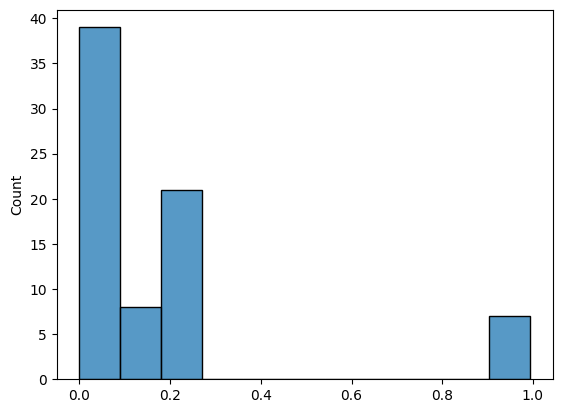

In [20]:
sns.histplot(data = df.isnull().sum().sort_index()/len(df_raw))

In [21]:
math.ceil(len(df.columns)/7)

11

In [22]:
def plot_distributions(df):
    # Calculate the number of rows and columns for the subplots
    num_rows = (len(df.columns) + 4) // 5
    num_cols = 5

    # Create subplots with the calculated number of rows and columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    # Flatten the axes array to iterate through subplots
    axes = axes.flatten()

    # Loop through columns and create KDE plots in each subplot
    for i, col in enumerate(df.columns):
        sns.kdeplot(df[col], fill=True, ax=axes[i])  # Use the current subplot
        axes[i].set_title(col)  # Set subplot title

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()

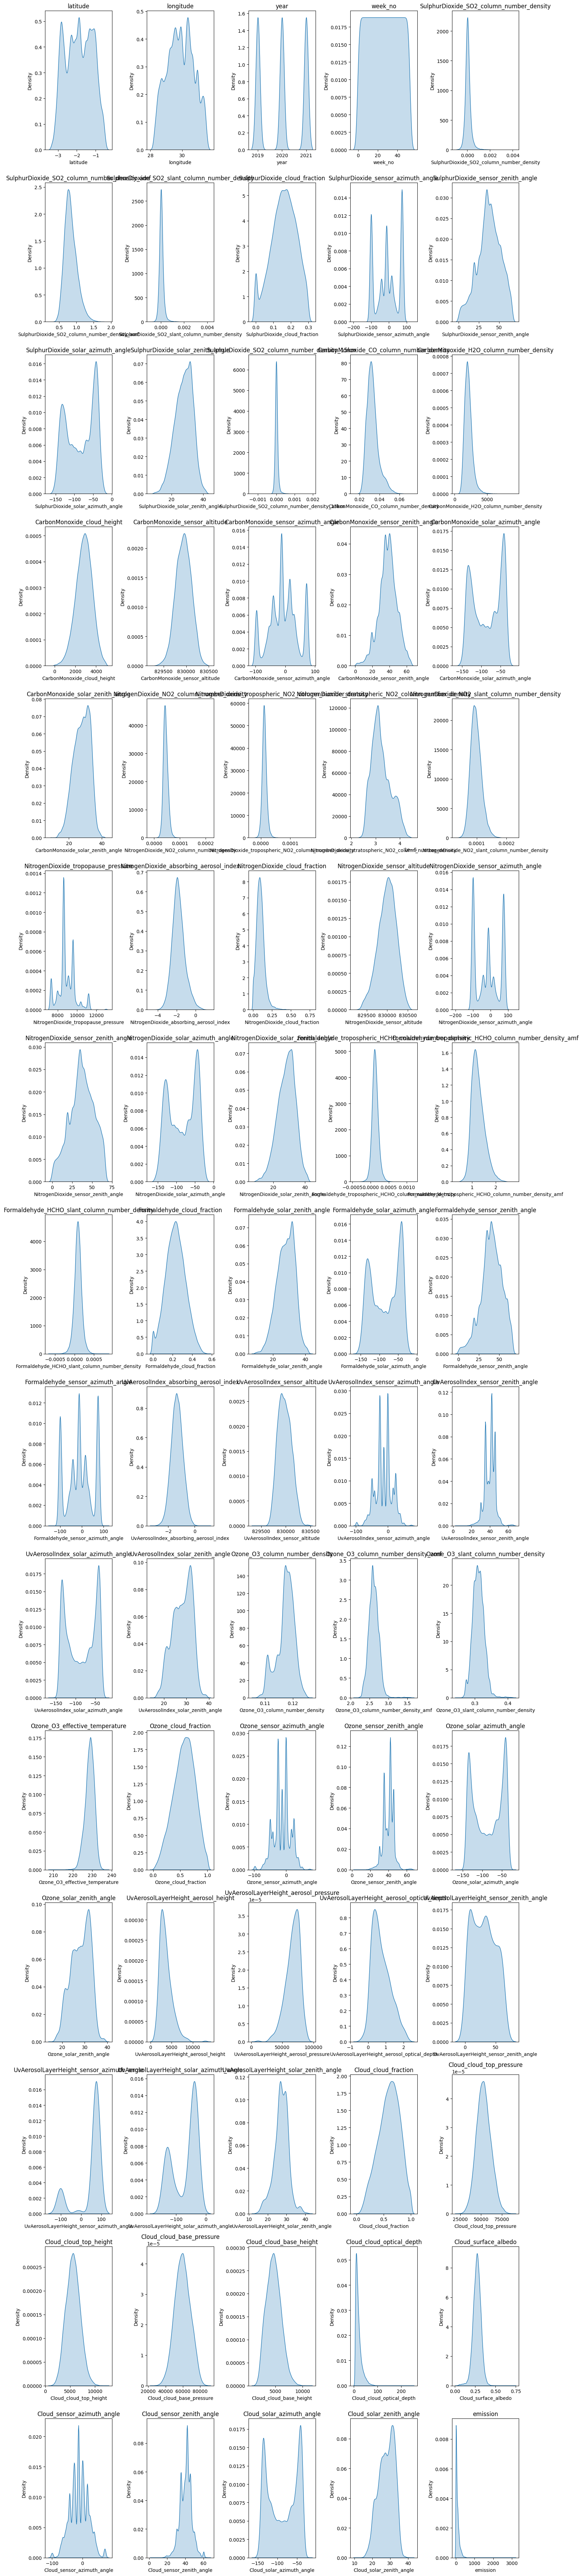

In [23]:
plot_distributions(df)

In [24]:
def fill_nan(df):
    median_values = df.groupby('year').transform('median')

    # Fill missing values with the calculated median values
    return df.fillna(median_values)

In [25]:
df_filled = fill_nan(df)

In [26]:
df_filled

latitude  longitude  year  week_no  \
0        -0.510     29.290  2019        0   
1        -0.510     29.290  2019        1   
2        -0.510     29.290  2019        2   
3        -0.510     29.290  2019        3   
4        -0.510     29.290  2019        4   
...         ...        ...   ...      ...   
79018    -3.299     30.301  2021       48   
79019    -3.299     30.301  2021       49   
79020    -3.299     30.301  2021       50   
79021    -3.299     30.301  2021       51   
79022    -3.299     30.301  2021       52   

       SulphurDioxide_SO2_column_number_density  \
0                                     -0.000108   
1                                      0.000021   
2                                      0.000514   
3                                      0.000013   
4                                     -0.000079   
...                                         ...   
79018                                  0.000284   
79019                                  0.000083   
79020                                  0.000018   
79021                                 -0.000034   
79022                                 -0.000091   

       SulphurDioxide_SO2_column_number_density_amf  \
0                                          0.603019   
1                                          0.728214   
2                                          0.748199   
3                                          0.832735   
4                                          0.676296   
...                                             ...   
79018                                      1.195643   
79019                                      1.130868   
79020                                      0.767034   
79021                                      0.879397   
79022                                      0.871951   

       SulphurDioxide_SO2_slant_column_number_density  \
0                                           -0.000065   
1                                            0.000014   
2                                            0.000385   
3                                            0.000010   
4                                           -0.000048   
...                                               ...   
79018                                        0.000340   
79019                                        0.000063   
79020                                        0.000013   
79021                                       -0.000028   
79022                                       -0.000079   

       SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
0                           0.255668                           -98.593887   
1                           0.130988                            16.592861   
2                           0.110018                            72.795837   
3                           0.159868                           -12.588154   
4                           0.121164                             4.121269   
...                              ...                                  ...   
79018                       0.191313                            72.820518   
79019                       0.177222                           -12.856753   
79020                       0.158926                           -10.176720   
79021                       0.184209                          -100.344827   
79022                       0.000000                            76.825638   

       SulphurDioxide_sensor_zenith_angle  ...  Cloud_cloud_top_height  \
0                               50.843559  ...             3664.436218   
1                               39.137194  ...             3651.190311   
2                               52.868816  ...             4216.986492   
3                               38.121075  ...             5228.507736   
4                               35.515587  ...             3980.598120   
...                                   ...  ...                     ...   
79018                           55.988022  ...             5459.

In [27]:
display_all(df_filled.isnull().sum().sort_index()/len(df_filled))

CarbonMonoxide_CO_column_number_density                     0.000000
CarbonMonoxide_H2O_column_number_density                    0.000000
CarbonMonoxide_cloud_height                                 0.000000
CarbonMonoxide_sensor_altitude                              0.000000
CarbonMonoxide_sensor_azimuth_angle                         0.000000
CarbonMonoxide_sensor_zenith_angle                          0.000000
CarbonMonoxide_solar_azimuth_angle                          0.000000
CarbonMonoxide_solar_zenith_angle                           0.000000
Cloud_cloud_base_height                                     0.000000
Cloud_cloud_base_pressure                                   0.000000
Cloud_cloud_fraction                                        0.000000
Cloud_cloud_optical_depth                                   0.000000
Cloud_cloud_top_height                                      0.000000
Cloud_cloud_top_pressure                                    0.000000
Cloud_sensor_azimuth_angle        

In [28]:
display_all(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   latitude                                                  79023 non-null  float64
 1   longitude                                                 79023 non-null  float64
 2   year                                                      79023 non-null  int64  
 3   week_no                                                   79023 non-null  int64  
 4   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 5   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 6   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 7   SulphurDioxide_cloud_fraction                             64414 non-null  float64
 8   SulphurDioxide_s

None

In [29]:
del_columns = df.columns[df.columns.str.startswith('UvAerosolLayerHeight')].to_list()

In [30]:
def drop_del(dataset):
    dataset = dataset.drop(del_columns, axis = 1)
    return dataset

In [31]:
df_filled = drop_del(df_filled)

In [32]:
X = df_filled.drop('emission', axis=1)
y = df_filled.emission

In [33]:
base_model.fit(X, y)

DecisionTreeRegressor()

In [34]:
test_df = test_raw.copy()

In [35]:
test_df = drop_id(test_df)

In [36]:
test_df = fill_nan(test_df)

In [37]:
test_df = drop_del(test_df)

<ipython-input-22-0be66fe602e9>:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], fill=True, ax=axes[i])  # Use the current subplot


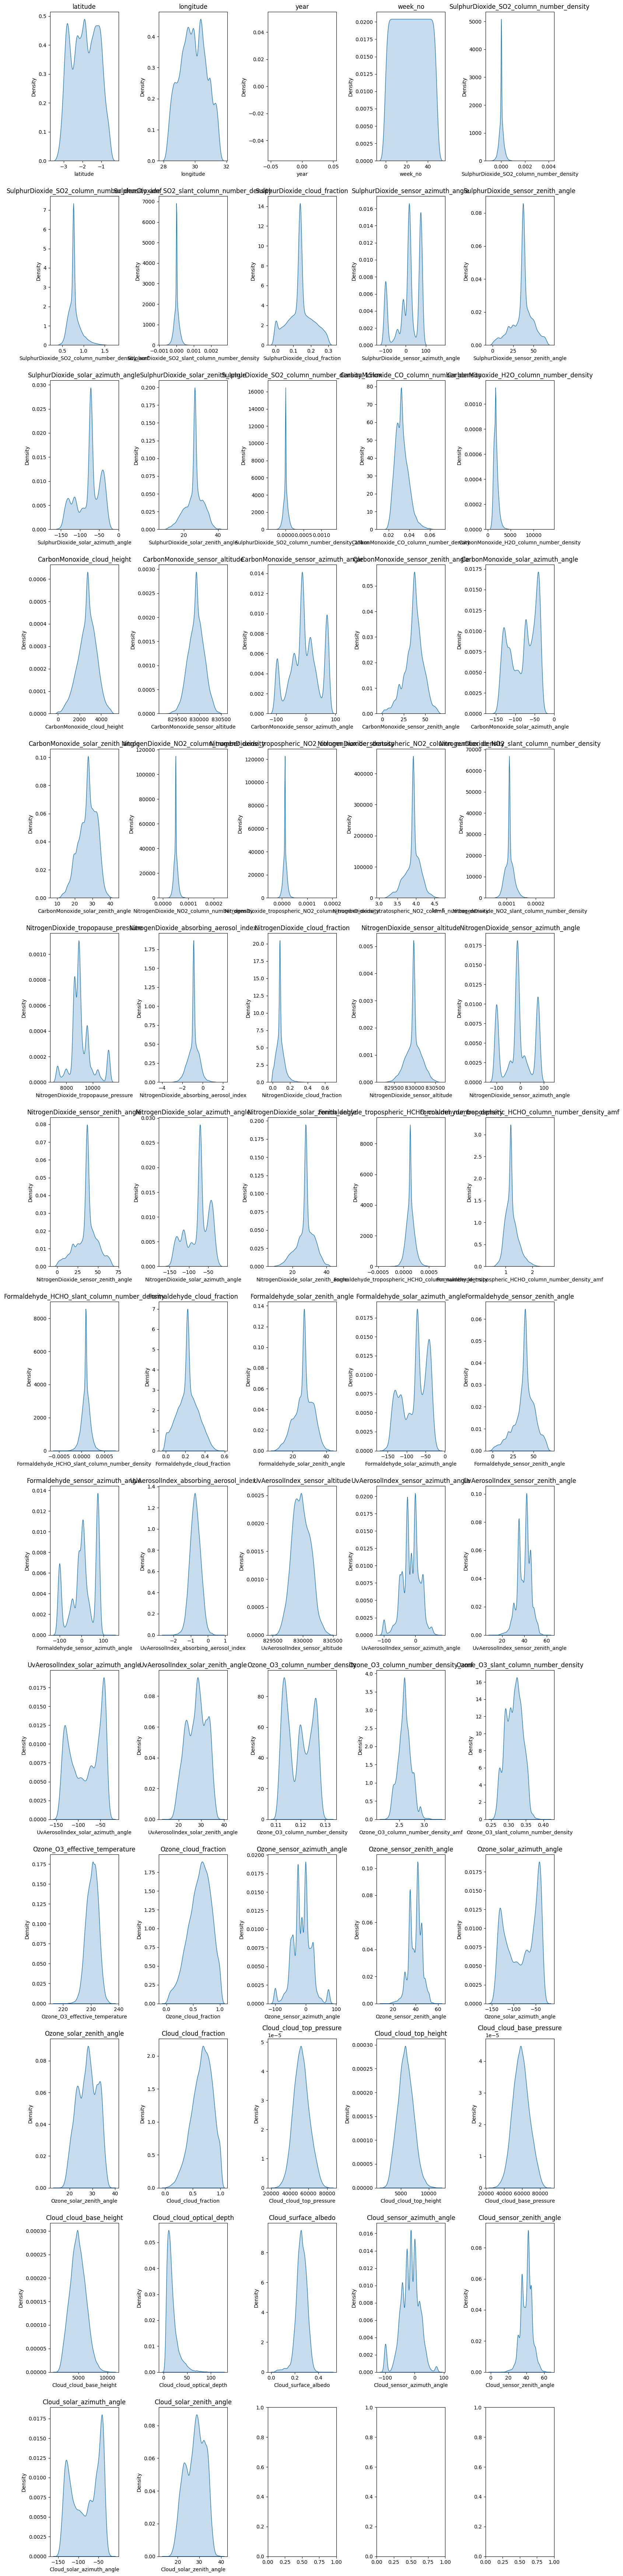

In [38]:
plot_distributions(test_df)

In [39]:
y_test = base_model.predict(test_df)

In [40]:
test_id = test_raw["ID_LAT_LON_YEAR_WEEK"]

In [41]:
# RF
from sklearn.ensemble import RandomForestRegressor

In [42]:
base_model2 = RandomForestRegressor(n_jobs=-1)

In [43]:
base_model2.fit(X, y)

RandomForestRegressor(n_jobs=-1)

In [44]:
y_test_rf = base_model.predict(test_df)

In [45]:
from xgboost import XGBRegressor

In [46]:
base_model3 = XGBRegressor()

In [47]:
base_model3.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
y_test_xgb = base_model3.predict(test_df)

In [49]:
type(test_id)

pandas.core.series.Series

In [50]:
submission_3 = pd.DataFrame(test_id)
submission_3['emission'] = y_test_xgb
submission_3.to_csv("base_submission3.csv", index=False)

### Validation

In [51]:
from sklearn.model_selection import train_test_split

We'll not use the train_test_split function because we have a time_series feature in the data

In [52]:
len(df_filled), len(df_filled[df_filled.year == 2019]), len(df_filled[df_filled.year == 2020]), len(df_filled[df_filled.year == 2021])

(79023, 26341, 26341, 26341)

In [53]:
len(test_df)

24353

In [54]:
train = df_filled[df_filled.year != 2021]
val = df_filled[df_filled.year == 2021]

In [55]:
X_train = train.drop('emission', axis=1)
y_train = train['emission']

In [56]:
X_val = val.drop('emission', axis=1)
y_val = val['emission']

In [57]:
base_model2.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [58]:
y_pred_val = base_model2.predict(X_val)

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
#Train
mean_squared_error(y_train, base_model2.predict(X_train), squared=False)

7.539243341451921

In [61]:
#Train
r2_score(y_train, base_model2.predict(X_train))

0.9972282134732645

In [62]:
#Val
mean_squared_error(y_val, y_pred_val, squared=False)

28.781825630661416

In [63]:
# Val
r2_score(y_val, y_pred_val)

0.9613845339760066

In [64]:
def predict_score(model):
    model.fit(X_train, y_train)
    score = [[mean_squared_error(y_train, model.predict(X_train), squared=False),
             r2_score(y_train, model.predict(X_train))],
             [mean_squared_error(y_val, model.predict(X_val), squared=False),
             r2_score(y_val, model.predict(X_val))]
    ]
    return score

In [65]:
test_model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
predict_score(test_model)

[[8.26642410731375, 0.9966677342985674],
 [29.35640032798947, 0.9598273752732256]]

In [66]:
test_model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
predict_score(test_model)

[[7.929277629535515, 0.9969340045535677],
 [29.06308377073304, 0.9606261400421211]]

In [67]:
test_model = RandomForestRegressor(n_estimators=60, n_jobs=-1)
predict_score(test_model)

[[7.861215021734476, 0.9969864138732244],
 [28.638556107161087, 0.9617680155460379]]

In [68]:
test_model = RandomForestRegressor(n_estimators=80, n_jobs=-1)
predict_score(test_model)

[[7.4824615124157585, 0.9972698076813021],
 [29.053441250738057, 0.9606522625453475]]

### Model Interpretation

In [69]:
test_model.feature_importances_

array([1.70405186e-01, 7.26258015e-01, 3.25448806e-03, 6.59525737e-02,
       2.59725393e-04, 4.57306071e-04, 3.36514207e-04, 7.33612607e-04,
       2.79840179e-04, 2.27957235e-04, 9.73734688e-04, 2.27762213e-04,
       3.61268703e-04, 1.21867107e-03, 5.53667834e-04, 4.25425500e-04,
       3.90094549e-04, 6.11165037e-04, 3.26484595e-04, 1.05746357e-03,
       4.41116782e-04, 2.71001404e-04, 2.60638638e-04, 3.77433003e-04,
       2.86712821e-04, 6.75864348e-04, 4.20457053e-04, 3.92901904e-04,
       2.90308919e-04, 2.92200668e-04, 2.90079271e-04, 3.38562071e-04,
       2.52498474e-04, 2.17012049e-04, 5.40420854e-04, 2.97064987e-04,
       4.15572956e-04, 3.00126325e-04, 7.20991214e-04, 4.99326693e-04,
       2.37780853e-04, 8.20300662e-04, 3.31917386e-04, 2.29011974e-04,
       1.25385879e-04, 9.48686303e-04, 4.05131192e-04, 5.11649694e-03,
       1.91734701e-04, 2.85575123e-04, 8.51299351e-04, 2.58767601e-04,
       2.35797345e-04, 1.30490875e-04, 1.01325605e-03, 7.19624893e-04,
      

In [70]:
def plot_feature_importances(model, feature_names, top_n=10, plot=True):
    """
    Plot the feature importances of a random forest model.

    Args:
        model (sklearn.ensemble.RandomForestClassifier or sklearn.ensemble.RandomForestRegressor): The trained random forest model.
        feature_names (list): List of feature names.
        top_n (int): Number of top features to display.
        plot (bool): Whether to display the feature importance plot.

    Returns:
        None
    """
    importances = model.feature_importances_
    indices = importances.argsort()[-top_n:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.title("Top Feature Importances")
        plt.barh(range(top_n), top_importances, align="center")
        plt.yticks(range(top_n), top_features)
        plt.xlabel("Feature Importance")
        plt.gca().invert_yaxis()
        plt.show()

    return top_features, top_importances

# Example usage:
# Assuming you have a trained random forest model named 'rf_model' and a list of feature names 'feature_names'
# top_features, top_importances = plot_feature_importances(rf_model, feature_names)


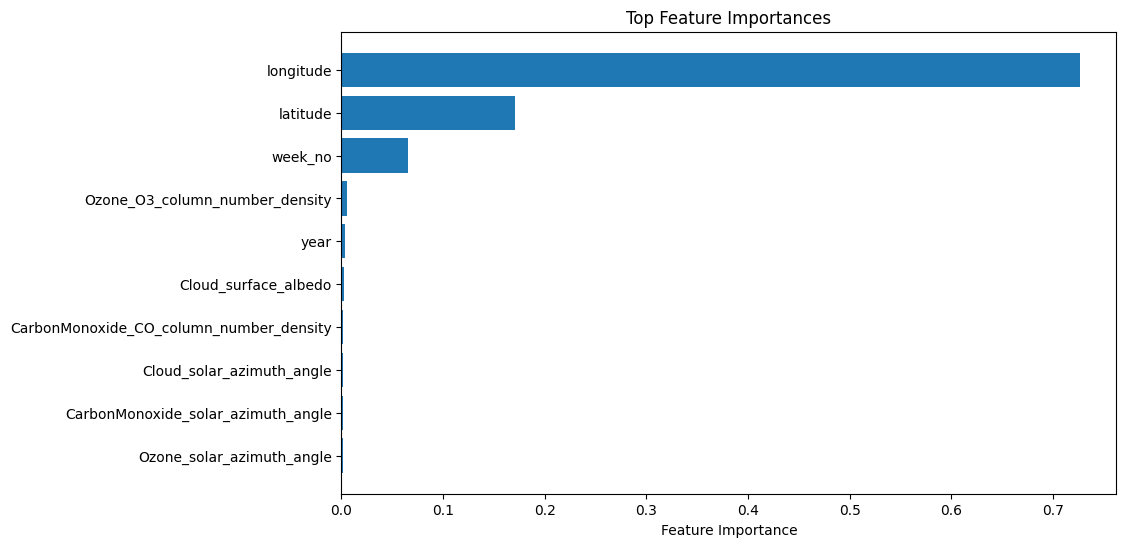

(['longitude',
  'latitude',
  'week_no',
  'Ozone_O3_column_number_density',
  'year',
  'Cloud_surface_albedo',
  'CarbonMonoxide_CO_column_number_density',
  'Cloud_solar_azimuth_angle',
  'CarbonMonoxide_solar_azimuth_angle',
  'Ozone_solar_azimuth_angle'],
 array([0.72625802, 0.17040519, 0.06595257, 0.0051165 , 0.00325449,
        0.00230541, 0.00121867, 0.0010992 , 0.00105746, 0.00101326]))

In [71]:
plot_feature_importances(test_model, X_train.columns.tolist(), top_n=10)